In [4]:
import os
import glob
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle

from pathlib import Path

from astropy.convolution import Gaussian2DKernel as g2
from astropy.convolution import Box2DKernel as b2
from astropy.convolution import convolve

In [14]:
#  flt_dir is the folder of the flat images you want to reduce
#  drk_dir is the folder of the drakimages 

flt_dir = 'data/F165/'
drk_dir = 'dark_ref/'

targets = glob.glob(flt_dir+'*flt.fits')  # the files we will be reducing


# make directories for the prodcut files, analysis plots 
# the directories will locate in the flat images directory. 
product_dir = flt_dir + 'product/'
plot_dir = product_dir + 'plot/'

Path(product_dir).mkdir(parents=True, exist_ok=True)
Path(plot_dir).mkdir(parents=True, exist_ok=True)

###### general parameters #########

# when below temp_cutoff, dark current can be neglected, perform sky_subtraction only
temp_cutoff = 22

# rf = mask radius of the galaxy for each filter. 
# sky_apt_size =  radius for the sky annulus. 
rf = 200
sky_apt_size = 150

# how many pixel on each side do you want to bin together   (if binning = 2,  bin 2*2 pixels )
# (1024%binning = 0)
binning = 25



In [6]:
# this function pull out the information from the header.  Doesn't have to be a class honestly.
# the only information we need for dark images are temperature and exposure time.

class prepare:
    
    def __init__(self, filename):
        
        
        
        
        file = fits.open(filename)
        
        # taking the parameters we need in the header: 
        # rootname, exposure time, temperature, filter, target coordinate 
        self.name = file[0].header['ROOTNAME']
        self.galname = file[0].header['TARGNAME']
        self.expt = file[0].header['EXPTIME']
        self.filter = file[0].header['FILTER1']
        self.RA = file[0].header['RA_TARG']
        self.DEC = file[0].header['DEC_TARG']
        self.temp = 0.5*(file[1].header['MDECODT1'] + file[1].header['MDECODT2'])
        
        # convert target coordinate (RA, DEC) into (pix_x, pix_y)
        w = WCS(file[('sci',1)].header, file)
        self.w_x, self.w_y=w.all_world2pix(file[0].header['RA_TARG'],file[0].header['DEC_TARG'],1, maxiter=50)
        
        file.close()
        
        # since np.nan-np.nan !=0 (happens on dark image, since there is no w_x)
        if self.w_x-self.w_x ==0 :   
            self.r_f = rf
            self.r_lim= int(min(1012-self.w_x, self.w_x-12, 1012-self.w_y, self.w_y-12))
        else:
            self.r_f=150
            self.r_lim= 350
          
        # new_name is the name of the product file
        self.new_name = self.name + '_fd.fits'
        self.path = product_dir + self.new_name
 



In [7]:
# We will make the circular mask for science image here 
# In this class we can get: circular mask, images, data quality maps

class mask_image: 
    def __init__(self, filename):
        self.filename=filename
        image = fits.getdata(filename)
        DQ = fits.getdata(filename, 3)  #Data Quality
        self.DQ = DQ
        # mask out the bad pixels as np.nan
        image_gp=image*0     # create an np.ndarray that has the same shape as "image", and work on this array
        image_gp[:,:]=image
        image_gp[DQ!=0]= np.nan # gp stands for good pixels. Only good pixels will return values
        
        
        self.image = image_gp
        self.nx, self.ny = np.shape(self.image)
        self.cent_x = prepare(filename).w_x
        self.cent_y = prepare(filename).w_y
        
    def cmask(self, r_out): 
        y, x = np.mgrid[0:self.ny, 0:self.nx]
        cent_x = self.cent_x
        cent_y = self.cent_y
        
        if cent_x-cent_x !=0:
            cent_x, cent_y = 512, 512
            # this happens when you are looking at dark images. 
            # In this code, the annulus always come from the science image. 
            
        mask_cir = [np.where(((x-cent_x)**2 + (y-cent_y)**2 >= 0.) \
                               & ((x-cent_x)**2 + (y-cent_y)**2 <= r_out**2)) ]
        
        return mask_cir[0]
        
    # this function return the annulus between r_in and r_out.  
    # If you need a circle, set r_in = 0
    def annulus(self, r_in, r_out): 
        y, x = np.mgrid[0:self.ny, 0:self.nx]
        cent_x = self.cent_x
        cent_y = self.cent_y
        
        if cent_x-cent_x !=0:
            cent_x, cent_y = 512, 512
            # this happens when you are looking at dark images. 
            # In this code, the annulus always come from the science image. 
            
        mask_annulus = [np.where(((x-cent_x)**2 + (y-cent_y)**2 >= r_in**2) \
                               & ((x-cent_x)**2 + (y-cent_y)**2 <= r_out**2)) ]
        
        return mask_annulus[0]
    
    # this function return the image with pixel[DQ!=0] = 0
    def image_DQ0(self):
        image = fits.getdata(self.filename)  
        image_gp=image*0     
        image_gp[:,:]=image
        image_gp[self.DQ!=0]= 0
        return image_gp
    
    # this function return the image regardless of DQ
    def image_noDQ(self):
        image = fits.getdata(self.filename)  
        return image
    
    
    

In [8]:
def bin_im(image, binning): 
    side= 1024%binning
    if side == 0:
        pass
    else: 
        ta = int(side/2)
        tb = side - ta
        image = image[ta:-tb,ta:-tb]
    
    return image.reshape(int(1024/binning), int(binning),int(1024/binning), int(binning)).mean(3).mean(1)




In [9]:
# function of sky subtraction, return the sky background 
def sky_value(filename): 
    r_f = prepare(filename).r_f
    sci = mask_image(filename)
    
    apt_size = sky_apt_size 
    
    sci_annulus = [sci.annulus(r_in =r_f+i, r_out=r_f+1+i)  for i in range(apt_size) ]
    m = [np.nanmean([sci.image[sci_annulus[i]]])  for i in range(apt_size)]
    
    sky_value = np.nanmedian(m)
    return sky_value

# function of dark current subtraction, return scale factors and a 2D array of residues
def dark_subtraction(filename): 

    sci = prepare(filename)
    
    sci_image = mask_image(filename).image_DQ0()
    sci_DQ = mask_image(filename).DQ   
    gal_mask = mask_image(filename).cmask(r_out = rf)
    
    
    sci_image[gal_mask] = 0
    


    
    drks = glob.glob(drk_dir+'*.fits') # the dark flat images
    drk_DQ=mask_image(drks[0]).DQ      # DQ map for all dark images are the same.
    DQ = sci_DQ+drk_DQ
    sci_image[DQ != 0] = 0
    
    sci_image_r = bin_im(sci_image, binning)

    residue_min=np.sum(sci_image_r**2)
    print('image varriance = ',residue_min )
    
    for i in range(len(drks)):
        # the parameter space of the dark current , A for the dark current scale, k for sky background
        A = np.linspace(0, 1, 11)
        K = np.linspace(0, 1e-2, 11)
        print('working on %s th dark image'%(i+1))
        drk = prepare(drks[i])
        drk_image = mask_image(drks[i]).image_noDQ()
        
        drk_image[DQ != 0] = 0  #np.nan    <---  it should be np.nan in the old algorithum,  but let's use 0 first 
        
        

        drk_image[gal_mask] = 0
        
        drk_image = bin_im(drk_image, binning)
        
        
        #### zoom in process####
        for j in range(20): 
            L = max(A)
            H = max(K)
            zoom=0.2
            residue = np.array([[np.sum((sci_image_r.flatten() - a*sci.expt/drk.expt*drk_image.flatten() - k)**2)\
                    for a in A ] for k in K])
            
            if np.min(residue.ravel()) < residue_min:
                residue_min = np.min(residue.ravel())
                best=np.where(residue==residue_min)
                ind, a_best, k_best = i, best[1], best[0]
                final_a , final_k = A[a_best], K[k_best]
                #print('the best match dark images so far has temp = ',drk.temp)
                #print('a, k = ',A[a_best][0], K[k_best][0])
                
            if A[a_best][0]-zoom*L <  0: 
                L1 = 0
            else: 
                L1 = A[a_best][0]-zoom*L
                
            if K[k_best][0]-zoom*H <  0: 
                H1 = 0
            else: 
                H1 = K[k_best][0]-zoom*H
                
                
     
            A = np.linspace(L1, A[a_best][0]+zoom*L , 11)
            K = np.linspace(H1, K[k_best][0]+zoom*H , 11)
            
          
            
        ########################
        
       
            
    if (len(K)-k_best <= 1) or  (len(A)-a_best <= 1): 
        print('Warning!!!  Scalars on the edge of the parameter sapce.')
        print('You may want to change the parameter limits and run again.')
        
    print('reduced smoothed varriance = ',residue_min )
    
    return ind, final_a*sci.expt/drk.expt, final_k
    

In [10]:
#  Here I will design the pipeline of dark current subtraction: 
def main(filename): 
    flt = prepare(filename)
    new_filename = flt.new_name
    print('########## begin subtraction for "%s" ###########'%flt.name)
    print('The science image has temp =',flt.temp)
    
    
    hdu = fits.open(filename)
    DQ = fits.getdata(filename, 3)
    
    # if flt.temp < temp_cutoff ,  perform sky subtraction only 
    if flt.temp < temp_cutoff:
        print(flt.name, ' temperature < %s, perform sky subtraction only'%temp_cutoff)
        
        sky = sky_value(filename)
        print('sky background = ', sky)
        hdu[1].data[DQ == 0] = hdu[1].data[DQ == 0] - sky
    
    # if flt.temp > temp_cutoff , perform sky+dark current subtraction 
    else:
        print('temperature > %s, perform sky+dark current subtraction'%temp_cutoff)
        drks = glob.glob(drk_dir+'*.fits')
        
        ind, a, sky = dark_subtraction(filename)
        
        d_hdu = mask_image(drks[ind])
        d_image = d_hdu.image_DQ0()

        
        hdu[1].data[DQ == 0] = hdu[1].data[DQ == 0] - a * d_image[DQ == 0] - sky
        
        
    
    # save file 
    path = flt.path 
    hdu.writeto(path, overwrite=True, output_verify="ignore")
    
    print('science image " %s " complete '%flt.name)
    #####################






In [12]:
# make plots
def make_plot(targets): 
    fig, ax = plt.subplots(3,len(targets),figsize=(7*len(targets)/3+2, 7))
    ax = ax.ravel()
    for i in range(len(targets)):
        file = targets[i]
        flt = prepare(file)
        name = flt.name
        fd_file = prepare(file).path

        t = flt.expt
        image0 = fits.getdata(file)/t*1e5
        image1 = fits.getdata(fd_file)/t*1e5
        DQ = fits.getdata(file, 3)



        norm1=simple_norm(image0, 'linear',min_cut=-1.5, max_cut=1.5)


        if flt.temp < temp_cutoff:
            ax0_title = 'sky subtraction'
            r_out = flt.r_f+100
        else: 
            ax0_title = 'sky+dark current subtraction'
            r_out = flt.r_lim


        theta = np.linspace(0, 2*np.pi, 100)

        r = flt.r_f

        cx = r*np.cos(theta) + flt.w_x
        cy = r*np.sin(theta) + flt.w_y





        ####### plot #######



        ax[i].set_title(ax0_title, fontsize=10)
        kernel = g2(10)
        image0[DQ!=0] = 0
        image0 =  convolve(image0, kernel, boundary=None)
        image0[DQ!=0] = 0
        im = ax[i].imshow(image0, cmap='PiYG', norm=norm1)
        ax[i].plot(cx, cy, color='k', lw = 1)

        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)

        plt.colorbar(im, cax=cax)



        ax[i + len(targets)].set_title(name, fontsize=10)
        kernel = g2(10)
        image1[DQ!=0] = 0
        image1 =  convolve(image1, kernel, boundary=None)
        image1[DQ!=0] = 0
        im = ax[i + len(targets)].imshow(image1, cmap='PiYG', norm=norm1)
        ax[i + len(targets)].plot(cx, cy, color='k', lw = 1)
        divider = make_axes_locatable(ax[i + len(targets)])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        norm1=simple_norm(image1/image0, 'linear',min_cut=-1.5, max_cut=1.5)
        ax[i + 2*len(targets)].set_title(name, fontsize=10)

        im = ax[i + 2*len(targets)].imshow(image1/image0, cmap='PiYG', norm=norm1)
        ax[i + 2*len(targets)].plot(cx, cy, color='k', lw = 1)
        divider = make_axes_locatable(ax[i + 2*len(targets)])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)







    plt.tight_layout()      
    path = plot_dir+str(binning)+'.png'       
    plt.show()  

    fig.savefig(path, dpi=400)

########## begin subtraction for "jdxv42nyq" ###########
The science image has temp = 26.3616
temperature > 22, perform sky+dark current subtraction
image varriance =  0.15782073
working on 1 th dark image
working on 2 th dark image
working on 3 th dark image
working on 4 th dark image
working on 5 th dark image
working on 6 th dark image
working on 7 th dark image
working on 8 th dark image
working on 9 th dark image
working on 10 th dark image
working on 11 th dark image
working on 12 th dark image
working on 13 th dark image
working on 14 th dark image
working on 15 th dark image
working on 16 th dark image
working on 17 th dark image
working on 18 th dark image
working on 19 th dark image
working on 20 th dark image
Warning!!!  Scalars on the edge of the parameter sapce.
You may want to change the parameter limits and run again.
reduced smoothed varriance =  0.027824808
science image " jdxv42nyq " complete 
########## begin subtraction for "jdxv43cbq" ###########
The science image 

/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


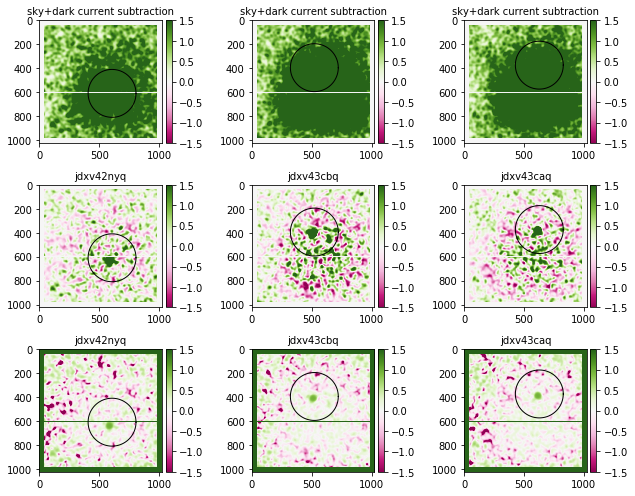

In [15]:
for i in range(len(targets)):
    filename = targets[i]
    
    main(filename)
    
make_plot(targets) # this step takes a long time  (gaussian convolution is slow)